In [5]:
import os
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import librosa
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import cv2
import splitfolders

In [6]:
# 创建文件夹
folder_path1 = '../data/dataset_2Dimages'
folder_path2 = '../data/dataset_2Dimages/MDD'
folder_path3 = '../data/dataset_2Dimages/Control'
if not os.path.exists(folder_path1):
    os.makedirs(folder_path1)
if not os.path.exists(folder_path2):
    os.makedirs(folder_path2)
if not os.path.exists(folder_path3):
    os.makedirs(folder_path3)

In [7]:
# 将1D EEG信号转换为2D频谱图(健康组)
path = "../data/EEG_dataset"  
MDD = os.path.join(path, "Control")  
listfile = os.listdir(MDD)

# 选择128个EEG信号通道中的部分通道
ch = [3,4,9,11,12,22,24,28,33,34,36,37,45,52,58,62,70,75,83,92,94,96,97,104,108,116,117,122,124]
save_path = "../data/dataset_2dimages/Control"  # 设置保存 2D 频谱图的路径

# 遍历控制组中的每个文件
for i in listfile:
    fpath = os.path.join(MDD, i)  # 获取当前文件的完整路径
    arrynp = np.load(fpath)  # 加载该文件中的numpy数组数据
    npfile = arrynp[:128, :]  # 选择前128行的数据

    # 对于我们选择的每个通道
    for jj in ch:
        signlfile = npfile[jj]  # 获取当前通道的EEG信号

        window_size = 1024  # 设置STFT窗口的大小
        window = np.hanning(window_size)  # 使用Hanning窗口（常用于频谱分析）
        # 计算STFT（短时傅里叶变换）
        stft = librosa.stft(signlfile, n_fft=window_size, hop_length=512, window=window)  # 计算STFT
        out = 2 * np.abs(stft) / np.sum(window)  # 计算幅度谱，归一化到 [0,1] 范围

        # 使用Matplotlib创建2D频谱图
        from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas  # 导入Matplotlib相关库
        fig = plt.Figure()  # 创建一个新的图表对象
        canvas = FigureCanvas(fig)  # 将图表对象转换为画布
        ax = fig.add_subplot(111)  # 创建一个坐标轴
        p = librosa.display.specshow(librosa.amplitude_to_db(out, ref=np.max), ax=ax, y_axis='log', x_axis='time')  # 显示频谱图，y轴为对数刻度，x轴为时间刻度

        # 将频谱图保存为PNG图像
        fig.savefig(os.path.join(save_path, str(i.split(".")[0]) + '_' + str(jj) + '.png'))  # 保存为图像文件，文件名为原始文件名+通道号


In [8]:
# 同样方法，将1D EEG信号转换为2D频谱图(抑郁症组)
path="../data/EEG_dataset"
save_path="../data/dataset_2dimages/MDD"
MDD=os.path.join(path,"MDD")

listfile=os.listdir(MDD)
ch=[3,4,9,11,12,22,24,28,33,34,36,37,45,52,58,62,70,75,83,92,94,96,97,104,108,116,117,122,124]

for i in listfile:
    fpath=os.path.join(MDD,i)
    arrynp=np.load(fpath)
    npfile=arrynp[:128,:]
    for jj in ch:
        signlfile=npfile[jj]
        window_size = 1024
        window = np.hanning(window_size)

        stft  = librosa.core.spectrum.stft(signlfile, n_fft=window_size, hop_length=512, window=window)
        out = 2 * np.abs(stft) / np.sum(window)

        from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
        fig = plt.Figure()
        canvas = FigureCanvas(fig)
        ax = fig.add_subplot(111)
        p = librosa.display.specshow(librosa.amplitude_to_db(out, ref=np.max),ax=ax,y_axis='log', x_axis='time')
        
        fig.savefig(os.path.join(save_path,str(i.split(".")[0])+'_'+str(jj)+'.png'))

(480, 640, 3)


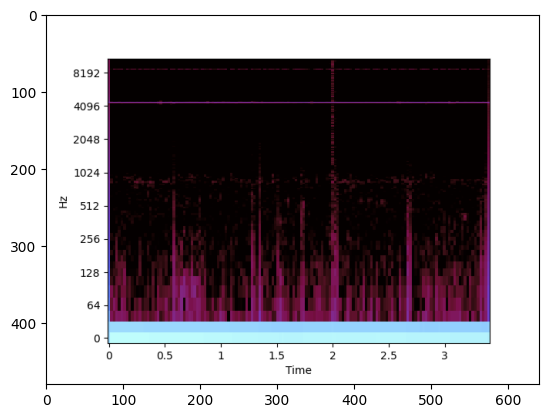

In [9]:
pathimg='../data/dataset_2Dimages/Control/02020008_104.png'
img=cv2.imread(pathimg)
print(img.shape)
plt.imshow(img)

In [10]:
input_folder = '../data/dataset_2Dimages'  # 数据集文件夹路径
output = '../data/train_val_test_2Ddataset'  # 分割后的训练集、验证集和测试集的文件夹路径

# 分割成比例为70%训练集、15%验证集、15%测试集
splitfolders.ratio(input_folder, output=output, seed=1337, ratio=(0.7, 0.15, 0.15), group_prefix=None, move=False)

Copying files: 1537 files [00:02, 695.92 files/s]


In [11]:
# 定义数据预处理（transformations）

# 定义训练集的预处理过程
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 将图像统一调整为 224x224 的大小
    transforms.RandomHorizontalFlip(),  # 数据增强:随机水平翻转图像
    transforms.ToTensor(),  # 将图像转换为PyTorch的张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 使用ImageNet数据集的均值和标准差进行标准化
])

# 定义验证集的预处理过程
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

# 定义测试集的预处理过程
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

# 加载数据集
train_dataset_path = '../data/train_val_test_2Ddataset/train'
val_dataset_path = '../data/train_val_test_2Ddataset/val'
test_dataset_path = '../data/train_val_test_2Ddataset/test'

# 使用ImageFolder加载训练集、验证集和测试集
train_dataset = datasets.ImageFolder(root=train_dataset_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dataset_path, transform=val_transform)
test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=test_transform)

# 打印训练集、验证集和测试集的样本数量
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

# 检查训练集中的第一个样本（图像和标签）
img, label = train_dataset[0]
print(img.shape)
print(label)

1075
230
232
torch.Size([3, 224, 224])
0


In [12]:
# 创建 DataLoader
# DataLoader帮助我们批量加载数据，进行数据的打乱、并行加载等操作

# 定义批次大小
batch_size = 32

# 创建训练集 DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# 创建验证集 DataLoader
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# 创建测试集 DataLoader
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# 检查训练集中的一个批次的图像和标签
for i, d in enumerate(train_loader):
    img_b, label_b = d
    print(img_b.shape)  # 输出批次的图像尺寸 (batch_size, channels, height, width)
    print(label_b)  # 输出批次的标签
    break

torch.Size([32, 3, 224, 224])
tensor([0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 0])


In [13]:
save_path='../data/Dataloader_2D'
if not os.path.exists(save_path):
    os.makedirs(save_path)

# 保存DataLoader的对象
torch.save(train_loader, os.path.join(save_path, 'train_loader.pth'))
torch.save(val_loader, os.path.join(save_path, 'val_loader.pth'))
torch.save(test_loader, os.path.join(save_path, 'test_loader.pth'))